In [1]:
import numpy as np
import pandas as pd
# Problem 1: load data, and print some rows in cell 2
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
raw_dataset['Origin'] = raw_dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [2]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [3]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
dataset = dataset.dropna()

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
test_dataset['Acceleration'] = 2*(np.random.rand(test_dataset['Acceleration'].shape[0])-0.5)

<IPython.core.display.Javascript object>


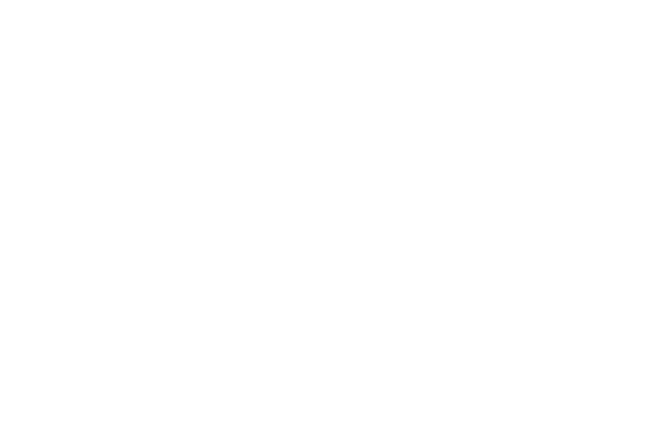

In [6]:
# Plot the quantity of interest (MPG) vs each input parameter
%matplotlib notebook
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6,1)
axes[0].plot(dataset['Cylinders'], dataset['MPG'], 'x')
axes[1].plot(dataset['Displacement'], dataset['MPG'], 'x')
axes[2].plot(dataset['Horsepower'], dataset['MPG'], 'x')
axes[3].plot(dataset['Weight'], dataset['MPG'], 'x')
axes[4].plot(dataset['Acceleration'], dataset['MPG'], 'x')
axes[5].plot(dataset['Model Year'], dataset['MPG'], 'x')
#axes[0].bar(dataset['Origin'], dataset['MPG'], 'x')


In [7]:
# MPG = a4*cylinders + a3*displacement + a2*horsepower + a1*weight ... + a0
# fuel used ~ cylinders*displacement*weight 
# engine efficiency ~ horsepower/(cylinders*displacement)

from scipy.optimize import least_squares

def mpg_stat(dataset, p):
    return p[0] + p[1]*dataset['Cylinders'] + p[2]*dataset['Displacement'] + p[3]*dataset['Horsepower'] + p[4]*dataset['Weight'] + p[5]*dataset['Acceleration'] + p[6]*dataset['Model Year'] + p[7]*dataset['Cylinders']*dataset['Displacement']*dataset['Weight'] + p[8]*dataset['Horsepower']/(dataset['Cylinders']*dataset['Displacement'])


def mpg_resid(data, p):
    return data['MPG'] - mpg_stat(data,p)

fit = least_squares(lambda x: mpg_resid(train_dataset, x),x0=9*[1])
print(fit)

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 1363.8266094558696
         fun: array([-0.63594611, -3.44702013, -0.59383687,  1.97945336,  0.21224272,
       -2.27219122,  2.67595364,  5.18798878,  0.29026978, -5.10727115,
       -2.39732869,  0.91231263, -0.7280381 , -2.43359978, -1.26810761,
        0.06990625, -2.26235289,  0.64284366,  0.5376048 ,  1.26706838,
       -5.92460553,  0.71613793, -3.25106944, -1.53188538,  8.33749282,
        1.61287821, -3.20351486, -1.27201645, -0.66271545,  2.28257781,
       -0.49858813,  1.44307858, -1.92020421, -4.27216877,  1.16817116,
        1.90169002,  2.12595678, -1.28485633, -0.29027442,  2.4729016 ,
        2.28450961,  8.39385597,  1.24197591,  1.1329431 , -3.14822531,
       -0.85157568, -2.09710125, -0.75284236, -0.51322956, -1.86562582,
       -1.94810913,  2.0914452 ,  0.37204505, -1.7462411 ,  1.78538948,
        4.68553979, -5.3298524 ,  3.11325711, -0.66270435, -4.34896363,
        3.78595346, -4.64264943

<IPython.core.display.Javascript object>


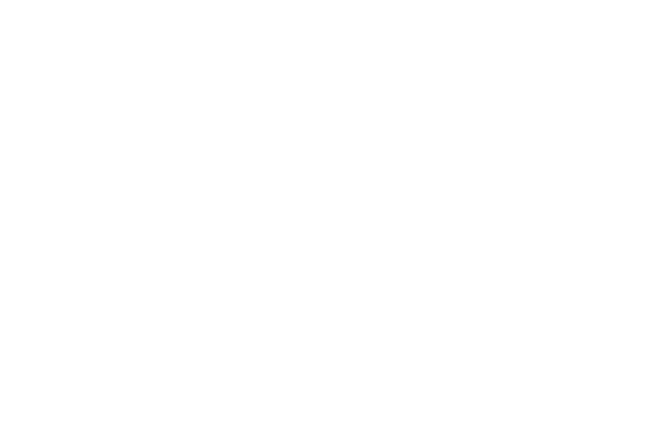

In [8]:
%matplotlib notebook
plt.figure()
plt.xlabel("True MPG")
plt.ylabel("Pred MPG")
plt.plot(test_dataset['MPG'],mpg_stat(test_dataset,fit['x']), 'o')
plt.plot(np.array(range(40)),np.array(range(40)))

In [9]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Convert origin to one-hot
train_features = pd.get_dummies(train_features, prefix='', prefix_sep='')
test_features = pd.get_dummies(test_features, prefix='', prefix_sep='')


train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_dataset.describe().transpose()[['mean', 'std']]
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2.3.0
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [10]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model


In [11]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [12]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

<IPython.core.display.Javascript object>


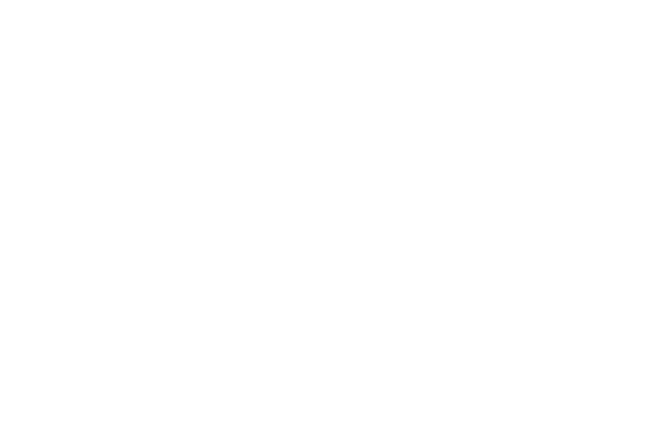

In [14]:
%matplotlib notebook
plot_loss(history)

<IPython.core.display.Javascript object>


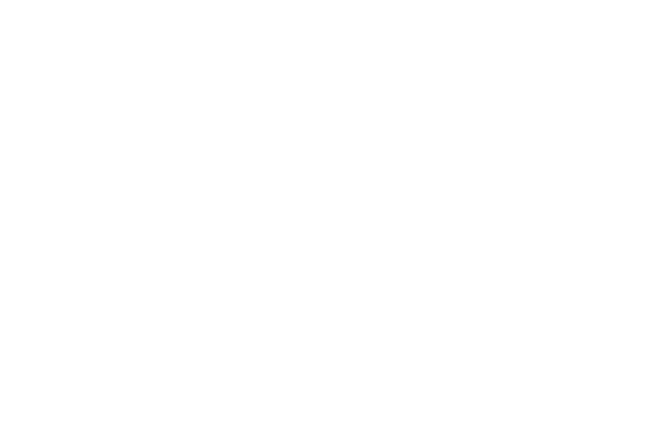

In [15]:
%matplotlib notebook
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

<IPython.core.display.Javascript object>


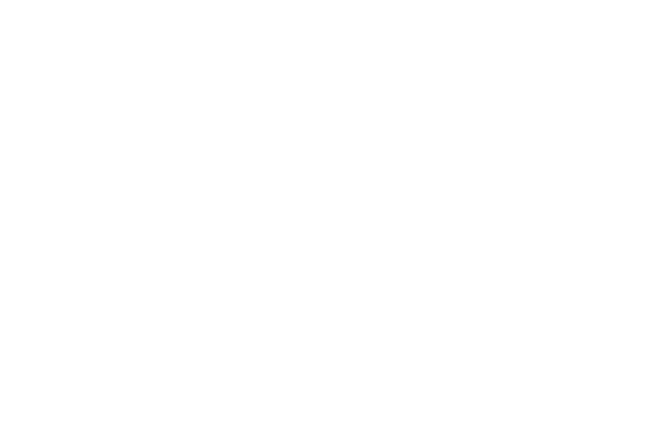

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.plot(test_dataset['MPG'],mpg_stat(test_dataset,fit['x']),'x',label='Physics Model')
plt.plot(test_labels, test_predictions, 'o', label='ML Model')
plt.plot(np.array(range(40)),np.array(range(40)))
plt.legend()

<IPython.core.display.Javascript object>


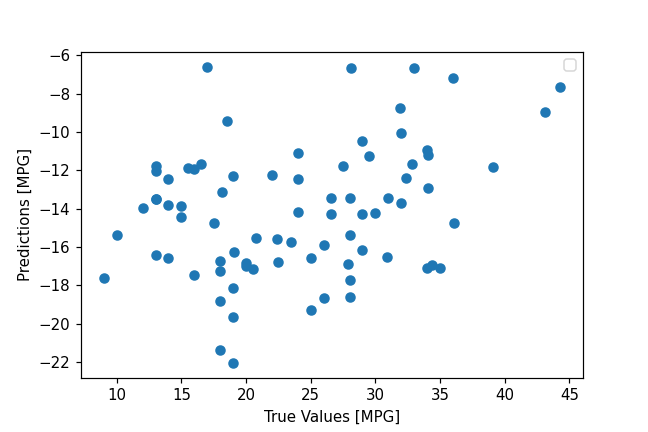

No handles with labels found to put in legend.


In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.plot(test_labels, mpg_stat(test_dataset,fit['x'])-test_predictions, 'o')
plt.legend()